In [8]:
!pip install numpy pandas scipy
import sys
!{sys.executable} -m pip install scipy matplotlib
!{sys.executable} -m pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [10]:
# Memuat data
df_non_renew = pd.read_csv(
    r"C:\Florence\Campus stuff\Semester 5\Pemodelan Bidang Energi - PBE\TUBES - 11\Data Storage\Final Data\renewable-electricity-Indonesia_2000_2024.csv"
)

df_renew = pd.read_csv(
    r"C:\Florence\Campus stuff\Semester 5\Pemodelan Bidang Energi - PBE\TUBES - 11\Data Storage\Final Data\non-renewable-electricity-Indonesia_2000_2024.csv"
)

# Menggabungkan data berdasarkan Tahun
# Kita asumsikan 'Year' adalah kunci yang sama
df_merged = pd.merge(df_renew, df_non_renew, on='Year', suffixes=('_ren', '_non'))

# Definisi kolom (berdasarkan snippet data)
cols_renew = [
    'Electricity from biofuels - TWh', 
    'Electricity from hydro - TWh', 
    'Electricity from solar - TWh', 
    'Electricity from wind - TWh', 
    'Electricity from geothermal - TWh'
]
col_non_renew_total = 'Electricity from fossil fuels - TWh' # Menggunakan total fosil
col_nuclear = 'Electricity from nuclear - TWh'

# Menghitung Total TWh per kategori
# Membersihkan nama kolom dari spasi jika ada
df_merged.columns = df_merged.columns.str.strip()

# Hitung E1 (Renewable) dan E2 (Non-Renewable)
df_merged['E1_Renewable'] = df_merged[cols_renew].sum(axis=1)
df_merged['E2_NonRenewable'] = df_merged[col_non_renew_total] + df_merged[col_nuclear]
df_merged['Total_Energy'] = df_merged['E1_Renewable'] + df_merged['E2_NonRenewable']

# Menghitung Pangsa Pasar Observasi (s1 dan s2)
# s1 = Share Renewable, s2 = Share Non-Renewable
df_merged['s1_obs'] = df_merged['E1_Renewable'] / df_merged['Total_Energy']
df_merged['s2_obs'] = df_merged['E2_NonRenewable'] / df_merged['Total_Energy']

# Variabel waktu (t)
# Kita geser t agar t=0 adalah tahun awal data untuk kestabilan numerik
t_data = df_merged['Year'].values - df_merged['Year'].min()
years = df_merged['Year'].values
s1_data = df_merged['s1_obs'].values
s2_data = df_merged['s2_obs'].values

In [11]:
def logit_model(t, params):
    """
    Menghitung s1(t) dan s2(t) berdasarkan Persamaan (9) dan (7).
    fi(t) = gamma_i * t + gamma_0i
    """
    g1, g01, g2, g02 = params
    
    # Fungsi skor linear (Persamaan 7)
    f1 = g1 * t + g01
    f2 = g2 * t + g02
    
    # Denominator Logit (Persamaan 9): 1 + exp(f1) + exp(f2)
    # Catatan: Dalam banyak model shares yang totalnya 100%, angka '1' 
    # kadang merepresentasikan 'outside option'. Jika s1+s2=1, model ini
    # mungkin memerlukan penyesuaian, namun kita ikuti rumus teks secara ketat.
    denom = 1 + np.exp(f1) + np.exp(f2)
    
    s1_pred = np.exp(f1) / denom
    s2_pred = np.exp(f2) / denom
    
    return s1_pred, s2_pred

def objective_function(params, t, s1_true, s2_true):
    """
    Fungsi objektif untuk meminimalkan Sum of Squared Errors (SSE).
    """
    s1_pred, s2_pred = logit_model(t, params)
    
    # Error gabungan s1 dan s2
    error = np.sum((s1_true - s1_pred)**2) + np.sum((s2_true - s2_pred)**2)
    return error

In [12]:
# Tebakan awal parameter [gamma1, gamma01, gamma2, gamma02]
# Kita tebak gamma kecil (pertumbuhan lambat) dan gamma0 menyesuaikan level awal
initial_guess = [0.05, -2.0, 0.05, 1.0]

# Optimasi
result = minimize(objective_function, initial_guess, args=(t_data, s1_data, s2_data), method='BFGS')
fitted_params = result.x

gamma1, gamma01, gamma2, gamma02 = fitted_params

print("=== Hasil Estimasi Parameter (Model Logit) ===")
print(f"Gamma 1 (Laju Intrinsik Terbarukan)     : {gamma1:.5f}")
print(f"Gamma 2 (Laju Intrinsik Non-Terbarukan) : {gamma2:.5f}")
print(f"Gamma 01 (Intersep Terbarukan)          : {gamma01:.5f}")
print(f"Gamma 02 (Intersep Non-Terbarukan)      : {gamma02:.5f}")

# Hitung Koefisien Interaksi Implisit (h_ij) jika diasumsikan rasio kaku (Persamaan 8 membantah ini,
# tapi secara matematis dari eq 6, 1/hij sebanding dengan gj/gi)
h12_implied = gamma1 / gamma2
h21_implied = gamma2 / gamma1
print("\n=== Parameter Kompetisi Implisit (Jika asumsi rasio murni) ===")
print(f"h12 (Hambatan terhadap Energi Terbarukan) : {h12_implied:.5f}")
print(f"h21 (Hambatan terhadap Energi Non-Terbarukan) : {h21_implied:.5f}")

=== Hasil Estimasi Parameter (Model Logit) ===
Gamma 1 (Laju Intrinsik Terbarukan)     : 0.59206
Gamma 2 (Laju Intrinsik Non-Terbarukan) : 0.49848
Gamma 01 (Intersep Terbarukan)          : -0.25333
Gamma 02 (Intersep Non-Terbarukan)      : 2.57115

=== Parameter Kompetisi Implisit (Jika asumsi rasio murni) ===
h12 (Hambatan terhadap Energi Terbarukan) : 1.18772
h21 (Hambatan terhadap Energi Non-Terbarukan) : 0.84195


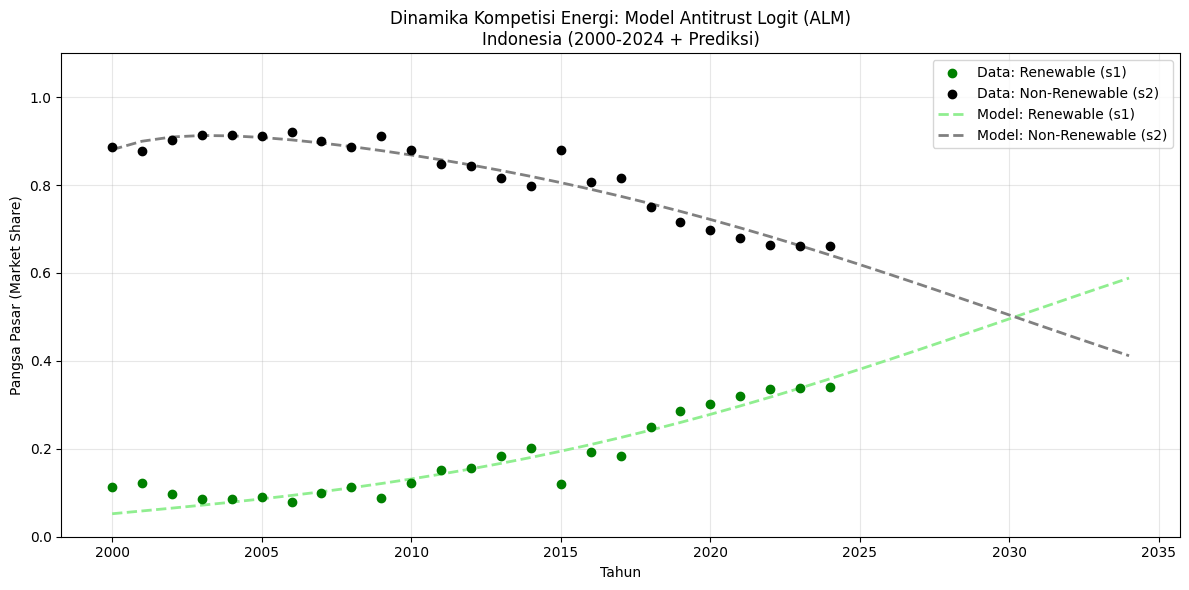

In [13]:
# Buat data prediksi untuk rentang waktu lebih panjang (Simulasi masa depan)
t_future = np.arange(0, len(t_data) + 10) # Prediksi 10 tahun ke depan
years_future = df_merged['Year'].min() + t_future

s1_pred, s2_pred = logit_model(t_future, fitted_params)

# Plotting
plt.figure(figsize=(12, 6))

# Plot Data Asli
plt.scatter(years, s1_data, color='green', label='Data: Renewable (s1)', zorder=5)
plt.scatter(years, s2_data, color='black', label='Data: Non-Renewable (s2)', zorder=5)

# Plot Model Fitting & Prediksi
plt.plot(years_future, s1_pred, color='lightgreen', linestyle='--', linewidth=2, label='Model: Renewable (s1)')
plt.plot(years_future, s2_pred, color='gray', linestyle='--', linewidth=2, label='Model: Non-Renewable (s2)')

plt.title('Dinamika Kompetisi Energi: Model Antitrust Logit (ALM)\nIndonesia (2000-2024 + Prediksi)')
plt.xlabel('Tahun')
plt.ylabel('Pangsa Pasar (Market Share)')
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, alpha=0.3)

# Menampilkan titik ekuilibrium (kondisi dimana s' = 0)
# Secara teoritis Logit akan jenuh di 1 atau 0, atau seimbang jika gamma = 0
plt.tight_layout()
plt.show()

In [14]:
# Menghitung turunan laju perubahan s1' pada tahun terakhir data
s1_last = s1_pred[len(t_data)-1]
s2_last = s2_pred[len(t_data)-1]

# Menggunakan Eq (10): s1' = gamma1 * s1 * (1 - s1 - (1/h12)*s2)
# Disini kita menggunakan h12 yang diimplikasikan dari hasil fitting logit agar konsisten
ds1_dt = gamma1 * s1_last * (1 - s1_last - (1/h12_implied) * s2_last)

print(f"\n=== Analisis Laju Perubahan (Tahun {years[-1]}) ===")
print(f"Pangsa Pasar Renewable Saat Ini : {s1_last:.4f}")
print(f"Laju Perubahan (ds1/dt)         : {ds1_dt:.5f} per tahun")
if ds1_dt > 0:
    print("Kesimpulan: Energi Terbarukan sedang dalam fase PERTUMBUHAN.")
else:
    print("Kesimpulan: Energi Terbarukan sedang dalam fase PENURUNAN/TEKANAN.")


=== Analisis Laju Perubahan (Tahun 2024) ===
Pangsa Pasar Renewable Saat Ini : 0.3592
Laju Perubahan (ds1/dt)         : 0.02154 per tahun
Kesimpulan: Energi Terbarukan sedang dalam fase PERTUMBUHAN.
